# Import Libs 

In [ ]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn.preprocessing import StandardScaler


import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

CURRENT_DATE = pd.to_datetime('01.04.2025', format='%d.%m.%Y')

# Read Data

In [2]:
data= pd.read_csv('data_retail.csv',sep=';')
data.head()

,TNX_ID,CUST_ID,CUST_BIRTH_DATE,GENDER,CITY,BALANCE_AMT,TNX_DATE_DDMMYYYY,TNX_TIME_HHMMSS,TNX_AMT
0,T1,K3635750,07.02.1953,M,DELHI,"398400,28",06.01.2025,141450,"26243,63"
1,T2,K6647259,05.07.1974,M,UDAIPUR,"11265,04",06.01.2025,131624,"137,63"
2,T3,K5488480,17.01.1987,F,PUNE,"441485,34",23.01.2025,200211,"9407,31"
3,T4,K2923826,06.09.1980,M,PUNE,"113206,71",08.01.2025,173743,"594,2"
4,T5,K7822327,07.10.1984,M,VADODARA,"21431,87",18.02.2025,213701,"493,74"


adjust date fields

In [3]:
print(f"initial birth date rate: % {data[data['CUST_BIRTH_DATE'].str.contains('/')==True].shape[0]*100/data.shape[0]} of the data")
data[data['CUST_BIRTH_DATE'].str.contains('/')==True].head()

initial birth date rate: % 5.468377463864591 of the data


,TNX_ID,CUST_ID,CUST_BIRTH_DATE,GENDER,CITY,BALANCE_AMT,TNX_DATE_DDMMYYYY,TNX_TIME_HHMMSS,TNX_AMT
7,T8,K4911924,1/1/1800,M,DELHI,"119395,7",17.01.2025,162512,"1955,82"
21,T22,K1417956,1/1/1800,M,MUMBAI,"59847,68",09.02.2025,61752,"998,28"
61,T62,K1941835,1/1/1800,M,BANGALORE,"324384,43",25.02.2025,103306,"595,88"
62,T63,K4016529,1/1/1800,M,NAVI MUMBAI,"126941,34",12.02.2025,15709,"281,16"
96,T97,K6516562,1/1/1800,F,MUMBAI,"11203,16",11.02.2025,202211,"463,3"


In [4]:
data['TNX_DATE_DDMMYYYY'] = pd.to_datetime(data['TNX_DATE_DDMMYYYY'], format = '%d.%m.%Y')
data['CUST_BIRTH_DATE'] = data['CUST_BIRTH_DATE'].replace("1/1/1800", np.nan)
data['CUST_BIRTH_DATE'] = pd.to_datetime(data['CUST_BIRTH_DATE'], format = '%d.%m.%Y')


# Ensure the time column is zero-padded to 6 digits
data['TNX_TIME_HHMMSS'] = data['TNX_TIME_HHMMSS'].astype(str).str.zfill(6)

# Convert to proper time format
data['TNX_TIME_HHMMSS'] = pd.to_datetime(data['TNX_TIME_HHMMSS'], format='%H%M%S').dt.time

data.head()

,TNX_ID,CUST_ID,CUST_BIRTH_DATE,GENDER,CITY,BALANCE_AMT,TNX_DATE_DDMMYYYY,TNX_TIME_HHMMSS,TNX_AMT
0,T1,K3635750,1953-02-07,M,DELHI,"398400,28",2025-01-06,14:14:50,"26243,63"
1,T2,K6647259,1974-07-05,M,UDAIPUR,"11265,04",2025-01-06,13:16:24,"137,63"
2,T3,K5488480,1987-01-17,F,PUNE,"441485,34",2025-01-23,20:02:11,"9407,31"
3,T4,K2923826,1980-09-06,M,PUNE,"113206,71",2025-01-08,17:37:43,"594,2"
4,T5,K7822327,1984-10-07,M,VADODARA,"21431,87",2025-02-18,21:37:01,"493,74"


handle duplicates

In [5]:
data[data.duplicated(['CUST_ID','TNX_DATE_DDMMYYYY'])].head()

,TNX_ID,CUST_ID,CUST_BIRTH_DATE,GENDER,CITY,BALANCE_AMT,TNX_DATE_DDMMYYYY,TNX_TIME_HHMMSS,TNX_AMT
10665,T10666,K3427762,1982-07-23,F,CHENNAI,"161612,24",2025-02-01,19:48:28,"619,55"
13590,T13591,K8513441,1991-03-20,M,BANGALORE,"4238,72",2025-03-01,22:41:34,"2380,37"
17531,T17532,K1437659,1992-01-17,M,TRIVANDRUM,"8258,98",2025-02-07,15:05:21,"310,6"
42534,T42535,K2511057,NaT,M,DELHI,"29364,12",2025-01-24,11:41:02,"1865,75"
43909,T43910,K2936183,1970-10-10,M,THANE,"132607,12",2025-01-17,15:49:28,"4826,69"


In [6]:
data[(data['CUST_ID']=='K3427762')]

,TNX_ID,CUST_ID,CUST_BIRTH_DATE,GENDER,CITY,BALANCE_AMT,TNX_DATE_DDMMYYYY,TNX_TIME_HHMMSS,TNX_AMT
5413,T5414,K3427762,1991-12-02,M,MADURAI,"20620,6",2025-02-01,13:12:10,"91,98"
10665,T10666,K3427762,1982-07-23,F,CHENNAI,"161612,24",2025-02-01,19:48:28,"619,55"
712326,T712327,K3427762,1984-07-29,M,MUMBAI,"686,78",2025-01-20,20:19:23,"2126,78"


In [7]:
data['CUST_ID'] = data['CITY'] + '_' + data['CUST_ID']
data[(data['CUST_ID']=='CHENNAI_K3427762')]

,TNX_ID,CUST_ID,CUST_BIRTH_DATE,GENDER,CITY,BALANCE_AMT,TNX_DATE_DDMMYYYY,TNX_TIME_HHMMSS,TNX_AMT
10665,T10666,CHENNAI_K3427762,1982-07-23,F,CHENNAI,"161612,24",2025-02-01,19:48:28,"619,55"


Missing Values %

<Axes: >

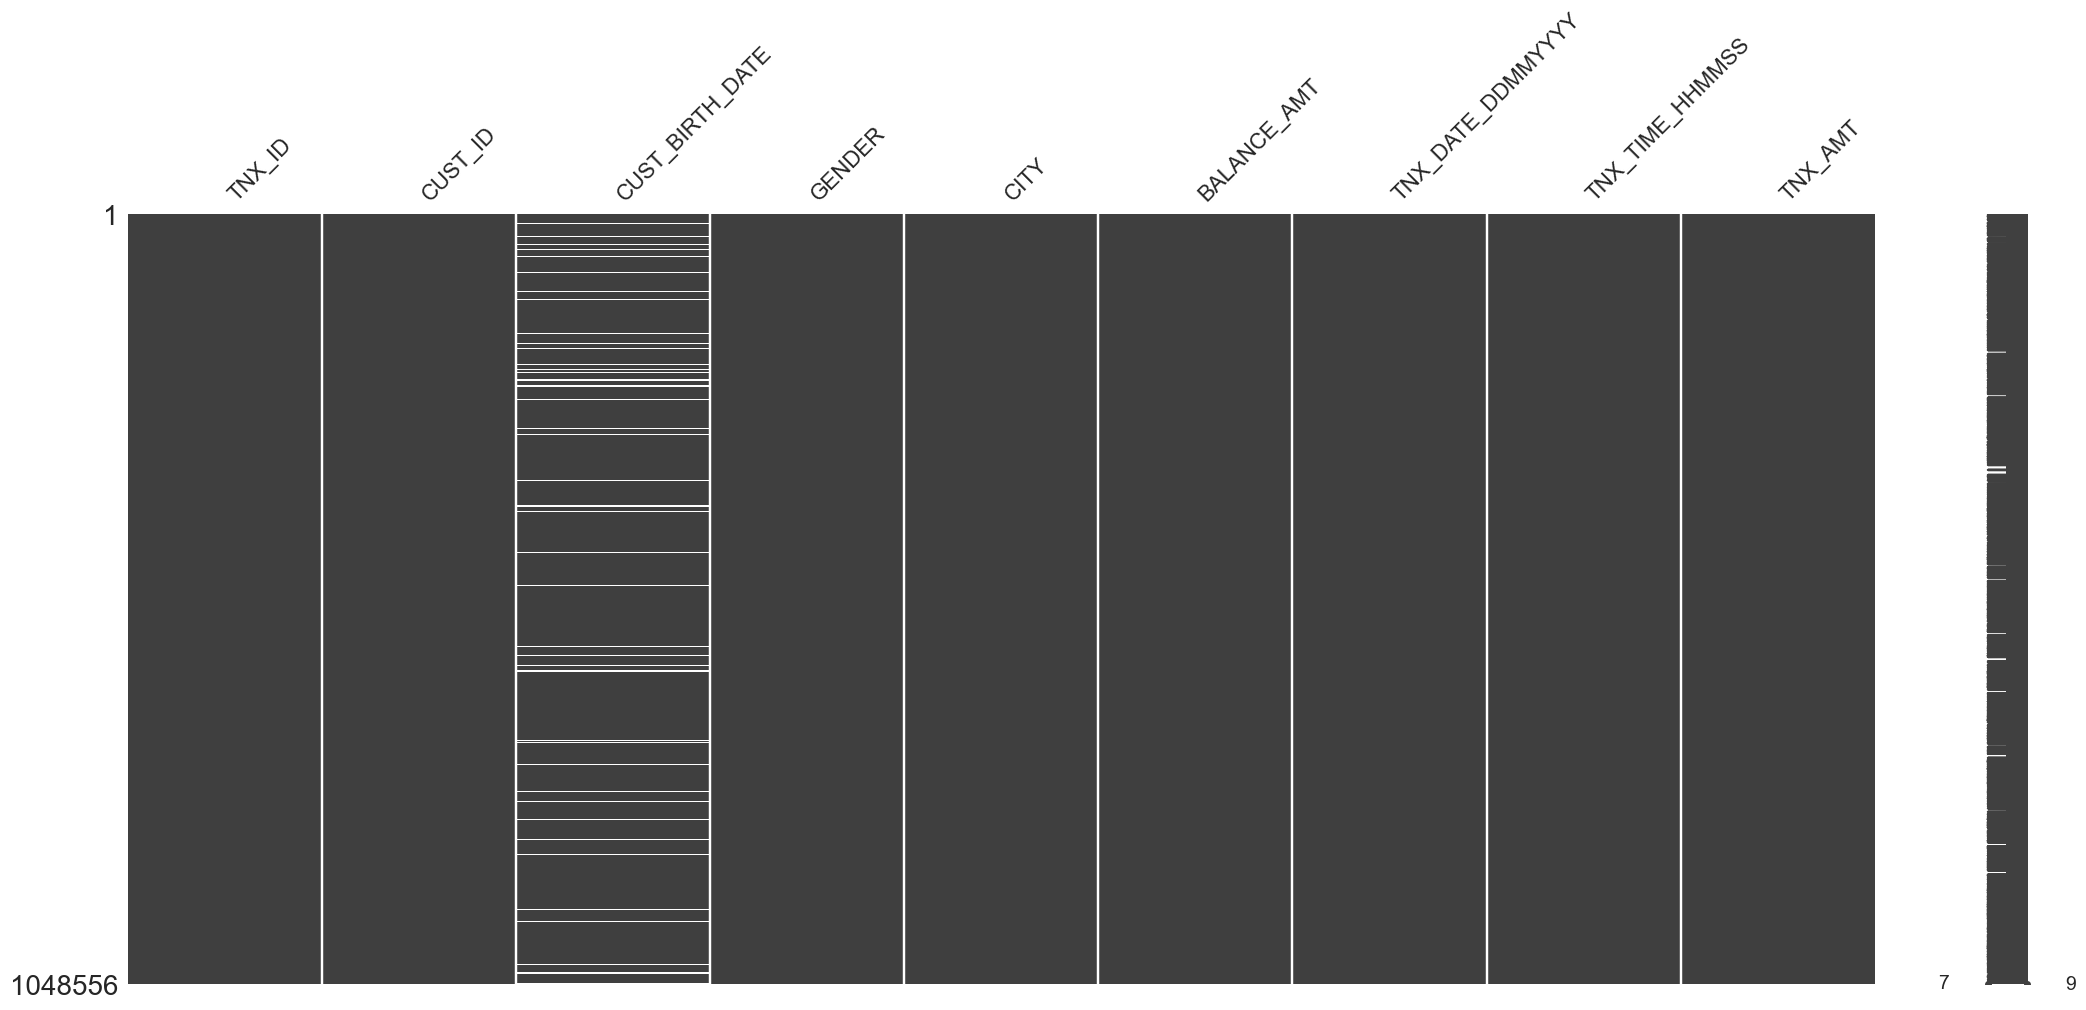

In [8]:
# Visualize missing values
msno.matrix(data)

In [9]:
data.isna().sum()*100/data.shape[0]

TNX_ID               0.000000
CUST_ID              0.014401
CUST_BIRTH_DATE      5.792347
GENDER               0.104906
CITY                 0.014401
BALANCE_AMT          0.000000
TNX_DATE_DDMMYYYY    0.000000
TNX_TIME_HHMMSS      0.000000
TNX_AMT              0.000000
dtype: float64

In [10]:
data = data.dropna()


you can adjust here. i directly exclude missing value records. you can fill them
- ie. ages might be filled w avg age of city and gender

In [11]:
# clean data which has larger birthday than current
data[data['CUST_BIRTH_DATE']>CURRENT_DATE].head()

,TNX_ID,CUST_ID,CUST_BIRTH_DATE,GENDER,CITY,BALANCE_AMT,TNX_DATE_DDMMYYYY,TNX_TIME_HHMMSS,TNX_AMT
2575,T2576,NEW DELHI_K3229030,2029-09-23,M,NEW DELHI,"34950,97",2025-01-08,12:34:10,"763,88"
14684,T14685,NEW DELHI_K2240340,2029-08-04,M,NEW DELHI,"20360,54",2025-01-11,18:02:24,"7415,59"
19893,T19894,THANE WEST_K7042826,2027-05-25,M,THANE WEST,"839141,61",2025-01-21,18:17:49,"212,65"
26525,T26526,NEW DELHI_K1724019,2029-04-01,M,NEW DELHI,"98934,77",2025-01-02,17:49:17,"339,47"
37428,T37429,NEW DELHI_K3440334,2029-08-04,M,NEW DELHI,"21330,58",2025-03-01,12:37:10,"25,84"


In [12]:
data = data[data['CUST_BIRTH_DATE'] < CURRENT_DATE]
data.head()

,TNX_ID,CUST_ID,CUST_BIRTH_DATE,GENDER,CITY,BALANCE_AMT,TNX_DATE_DDMMYYYY,TNX_TIME_HHMMSS,TNX_AMT
0,T1,DELHI_K3635750,1953-02-07,M,DELHI,"398400,28",2025-01-06,14:14:50,"26243,63"
1,T2,UDAIPUR_K6647259,1974-07-05,M,UDAIPUR,"11265,04",2025-01-06,13:16:24,"137,63"
2,T3,PUNE_K5488480,1987-01-17,F,PUNE,"441485,34",2025-01-23,20:02:11,"9407,31"
3,T4,PUNE_K2923826,1980-09-06,M,PUNE,"113206,71",2025-01-08,17:37:43,"594,2"
4,T5,VADODARA_K7822327,1984-10-07,M,VADODARA,"21431,87",2025-02-18,21:37:01,"493,74"


TNX_AMT and  BALANCE_AMT cols converted to float

In [13]:
data = data[data['TNX_AMT'] !=  '#ARG!']
data = data[data['BALANCE_AMT'] !=  '#ARG!']
data['TNX_AMT'] = data['TNX_AMT'].apply(lambda x:x.replace(',','.'))
data['TNX_AMT'] = data['TNX_AMT'].astype('float')
data['BALANCE_AMT'] = data['BALANCE_AMT'].apply(lambda x:x.replace(',','.'))
data['BALANCE_AMT'] = data['BALANCE_AMT'].astype('float')

In [14]:
data = data[data['TNX_AMT']>0]
data.head()

,TNX_ID,CUST_ID,CUST_BIRTH_DATE,GENDER,CITY,BALANCE_AMT,TNX_DATE_DDMMYYYY,TNX_TIME_HHMMSS,TNX_AMT
0,T1,DELHI_K3635750,1953-02-07,M,DELHI,398400.28,2025-01-06,14:14:50,26243.63
1,T2,UDAIPUR_K6647259,1974-07-05,M,UDAIPUR,11265.04,2025-01-06,13:16:24,137.63
2,T3,PUNE_K5488480,1987-01-17,F,PUNE,441485.34,2025-01-23,20:02:11,9407.31
3,T4,PUNE_K2923826,1980-09-06,M,PUNE,113206.71,2025-01-08,17:37:43,594.20
4,T5,VADODARA_K7822327,1984-10-07,M,VADODARA,21431.87,2025-02-18,21:37:01,493.74


Clean cities

note : city names have to be cleaned.

In [15]:
pattern = r"[()0-9]"
data[data["CITY"].str.contains(pattern, regex=True)]

,TNX_ID,CUST_ID,CUST_BIRTH_DATE,GENDER,CITY,BALANCE_AMT,TNX_DATE_DDMMYYYY,TNX_TIME_HHMMSS,TNX_AMT
75,T76,THANE (W) THANE_K8824512,1984-01-22,M,THANE (W) THANE,6474.38,2025-02-13,21:36:50,309.86
83,T84,CHITTO0R_K2840675,1984-08-30,M,CHITTO0R,6229.10,2025-02-12,19:51:31,3136.05
103,T104,(E) MUMBAI_K5728143,1984-02-02,M,(E) MUMBAI,19304.36,2025-02-20,20:17:00,360.96
386,T387,KORMANGALA 1ST BLOCK BANGALORE_K5555988,1990-12-15,M,KORMANGALA 1ST BLOCK BANGALORE,18391.41,2025-01-25,19:31:51,50.74
420,T421,SECT-24 AND 25A GURGAON_K2610831,1992-10-25,F,SECT-24 AND 25A GURGAON,167611.29,2025-01-23,18:52:58,307.90
...,...,...,...,...,...,...,...,...,...
1047956,T1047957,ELCO MARKET BANDRA (W) MUMBAI_K3810589,1981-12-22,M,ELCO MARKET BANDRA (W) MUMBAI,6283.92,2025-01-27,17:23:59,423.87
1048209,T1048210,CHITTO0R_K8729918,1993-11-18,F,CHITTO0R,10976.15,2025-01-22,17:31:33,297.65
1048236,T1048237,REWARI (HARYANA)_K4719236,1993-02-15,M,REWARI (HARYANA),30.80,2025-01-27,19:15:19,19.77
1048463,T1048464,THANE (W) THANE_K3810256,1982-03-15,M,THANE (W) THANE,4693.83,2025-02-06,11:18:52,37.06


Feature Engineering

In [16]:
# Calculate age
data['AGE'] = (CURRENT_DATE - data['CUST_BIRTH_DATE']).dt.days // 365
data = data[data['AGE'] >= 18]
data = data.drop('CUST_BIRTH_DATE',axis=1)
data.head()

,TNX_ID,CUST_ID,GENDER,CITY,BALANCE_AMT,TNX_DATE_DDMMYYYY,TNX_TIME_HHMMSS,TNX_AMT,AGE
0,T1,DELHI_K3635750,M,DELHI,398400.28,2025-01-06,14:14:50,26243.63,72
1,T2,UDAIPUR_K6647259,M,UDAIPUR,11265.04,2025-01-06,13:16:24,137.63,50
2,T3,PUNE_K5488480,F,PUNE,441485.34,2025-01-23,20:02:11,9407.31,38
3,T4,PUNE_K2923826,M,PUNE,113206.71,2025-01-08,17:37:43,594.20,44
4,T5,VADODARA_K7822327,M,VADODARA,21431.87,2025-02-18,21:37:01,493.74,40


Gender col label encoding

- M : 1
- F : 2

In [17]:
data['GENDER'] = data['GENDER'].map({'M': 1, 'F': 2})
data.head()

,TNX_ID,CUST_ID,GENDER,CITY,BALANCE_AMT,TNX_DATE_DDMMYYYY,TNX_TIME_HHMMSS,TNX_AMT,AGE
0,T1,DELHI_K3635750,1,DELHI,398400.28,2025-01-06,14:14:50,26243.63,72
1,T2,UDAIPUR_K6647259,1,UDAIPUR,11265.04,2025-01-06,13:16:24,137.63,50
2,T3,PUNE_K5488480,2,PUNE,441485.34,2025-01-23,20:02:11,9407.31,38
3,T4,PUNE_K2923826,1,PUNE,113206.71,2025-01-08,17:37:43,594.20,44
4,T5,VADODARA_K7822327,1,VADODARA,21431.87,2025-02-18,21:37:01,493.74,40


In [18]:
data.describe()

,GENDER,BALANCE_AMT,TNX_DATE_DDMMYYYY,TNX_AMT,AGE
count,965179.000000,9.651790e+05,965179,9.651790e+05,965179.000000
mean,1.278784,1.073032e+05,2025-01-27 07:03:45.176470528,1.474706e+03,39.356801
min,1.000000,0.000000e+00,2025-01-01 00:00:00,1.000000e-02,18.000000
25%,1.000000,4.973800e+03,2025-01-13 00:00:00,1.626500e+02,33.000000
50%,1.000000,1.656318e+04,2025-01-25 00:00:00,4.462000e+02,37.000000
75%,2.000000,5.483848e+04,2025-02-11 00:00:00,1.150305e+03,43.000000
max,2.000000,1.177910e+08,2025-03-30 00:00:00,1.619626e+06,95.000000
std,0.448401,8.217361e+05,NaN,6.214207e+03,8.743807


In [19]:
data.describe(include=[object]) 

,TNX_ID,CUST_ID,CITY,TNX_TIME_HHMMSS
count,965179,965179,965179,965179
unique,965179,958268,8027,81047
top,T1048556,NEW DELHI_K3710948,MUMBAI,19:33:03
freq,1,4,96110,46


RFM yap clustering icin

# EDA

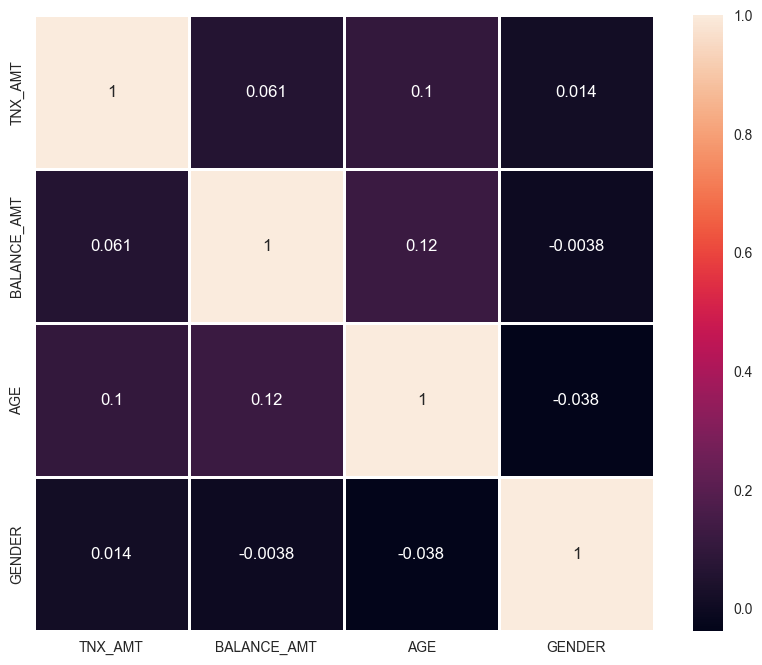

In [20]:
plt.figure(figsize = (10, 8))

sns.heatmap(data = data[['TNX_AMT','BALANCE_AMT','AGE','GENDER']].corr(), annot = True, fmt = '.2g', linewidth = 1)
plt.show()

gorsel  ekle biraz sonra clustering gec

Distribution of Transaction Amounts

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 965179 entries, 0 to 1048555
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   TNX_ID             965179 non-null  object        
 1   CUST_ID            965179 non-null  object        
 2   GENDER             965179 non-null  int64         
 3   CITY               965179 non-null  object        
 4   BALANCE_AMT        965179 non-null  float64       
 5   TNX_DATE_DDMMYYYY  965179 non-null  datetime64[ns]
 6   TNX_TIME_HHMMSS    965179 non-null  object        
 7   TNX_AMT            965179 non-null  float64       
 8   AGE                965179 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 73.6+ MB


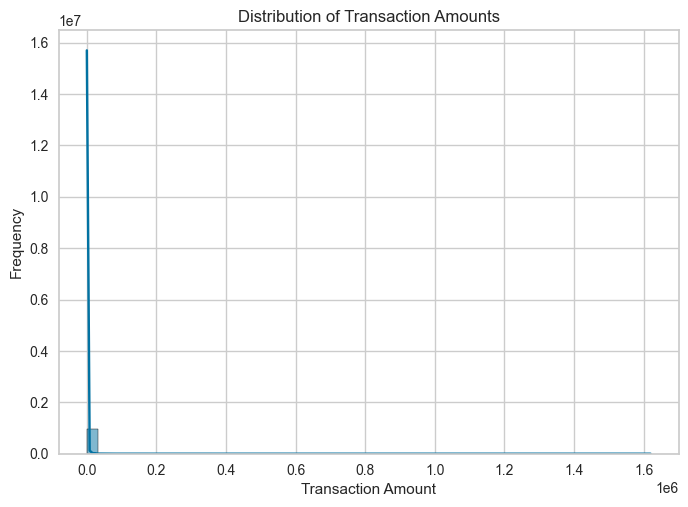

In [22]:
sns.histplot(data=data, x='TNX_AMT', bins=50, kde=True)
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.show()

In [23]:
print(f"Min Transaction Amount : {data['TNX_AMT'].min()} and Max Transactiın amount is : {data['TNX_AMT'].max()}")

Min Transaction Amount : 0.01 and Max Transactiın amount is : 1619626.48


Gender Distribution

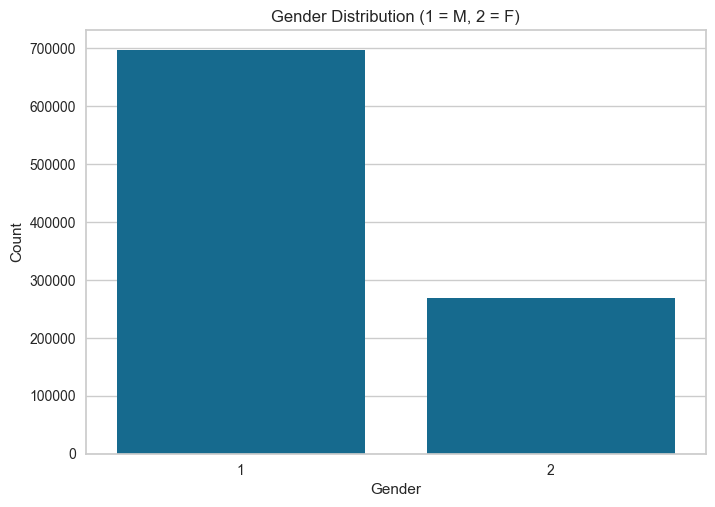

In [24]:
sns.countplot(data=data, x='GENDER')
plt.title("Gender Distribution (1 = M, 2 = F)")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

Top 10 Cities by Transaction Volume

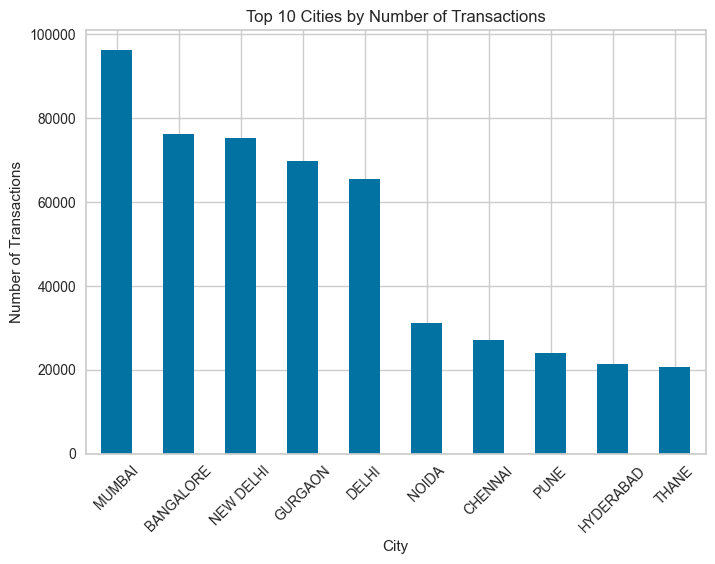

In [25]:
city_counts = data['CITY'].value_counts().head(10)
city_counts.plot(kind='bar')
plt.title("Top 10 Cities by Number of Transactions")
plt.xlabel("City")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.show()


Age Distribution

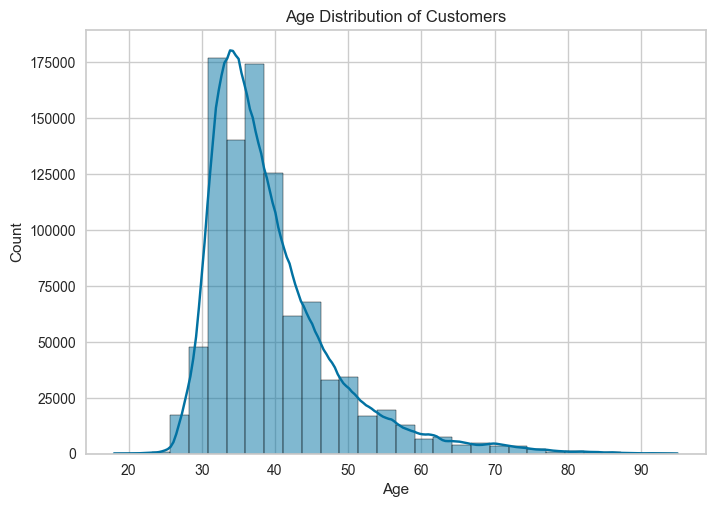

In [26]:
sns.histplot(data=data, x='AGE', bins=30, kde=True)
plt.title("Age Distribution of Customers")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

Transaction Amount by Gender

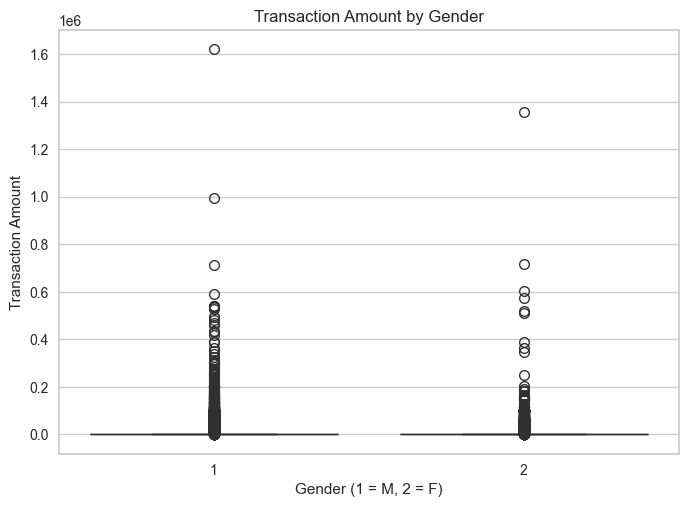

In [27]:
sns.boxplot(data=data, x='GENDER', y='TNX_AMT')
plt.title("Transaction Amount by Gender")
plt.xlabel("Gender (1 = M, 2 = F)")
plt.ylabel("Transaction Amount")
plt.show()

Daily Transaction Volume Over Time

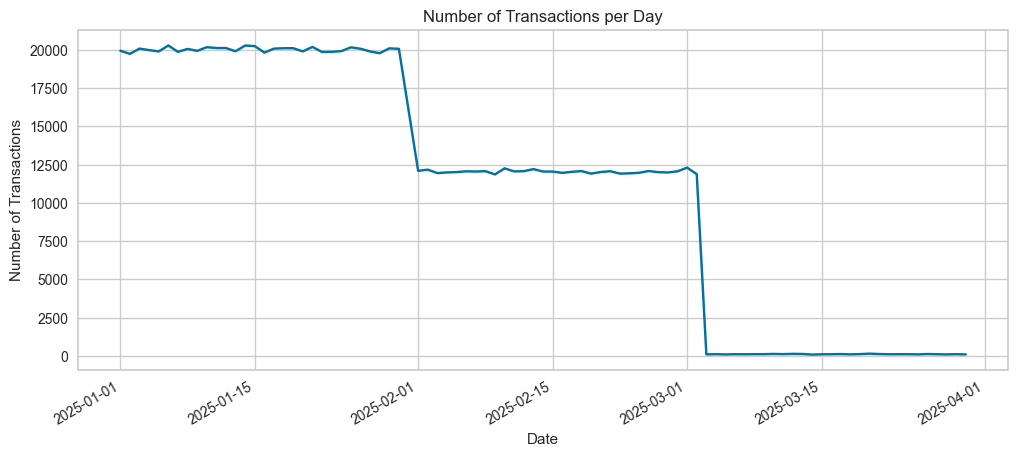

In [28]:
daily_tnx = data.groupby('TNX_DATE_DDMMYYYY')['TNX_ID'].count()

daily_tnx.plot(figsize=(12, 5))
plt.title("Number of Transactions per Day")
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.grid(True)
plt.show()

Feature Engineering devam 

In [29]:
# Calculate RFM metrics
rfm_data = data.groupby("CUST_ID").agg({
    "TNX_DATE_DDMMYYYY": lambda x: (CURRENT_DATE - x.max()).days,
    "TNX_ID": "count",
    "TNX_AMT": "sum"
}).reset_index()
rfm_data = rfm_data.rename(columns= {'TNX_DATE_DDMMYYYY':'Recency',
                                     'TNX_ID':'Frequency',
                                     'TNX_AMT':'Monetary'})
rfm_data.head()

,CUST_ID,Recency,Frequency,Monetary
0,(154) BHASKOLA FARIDABAD_K2728824,69,1,3241.49
1,(154) BHASKOLA FARIDABAD_K3028850,66,1,51.31
2,(154) BHASKOLA FARIDABAD_K3428855,38,1,1183.96
3,(154) BHASKOLA FARIDABAD_K3928834,51,1,46.93
4,(154) BHASKOLA FARIDABAD_K4128823,53,1,52.02


# Clustering

In [30]:
cluster_feature = ['Recency','Frequency','Monetary']
cluster_df = rfm_data[cluster_feature]
cluster_df.head()

,Recency,Frequency,Monetary
0,69,1,3241.49
1,66,1,51.31
2,38,1,1183.96
3,51,1,46.93
4,53,1,52.02


KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=9, random_state=42),
                 k=(2, 10))

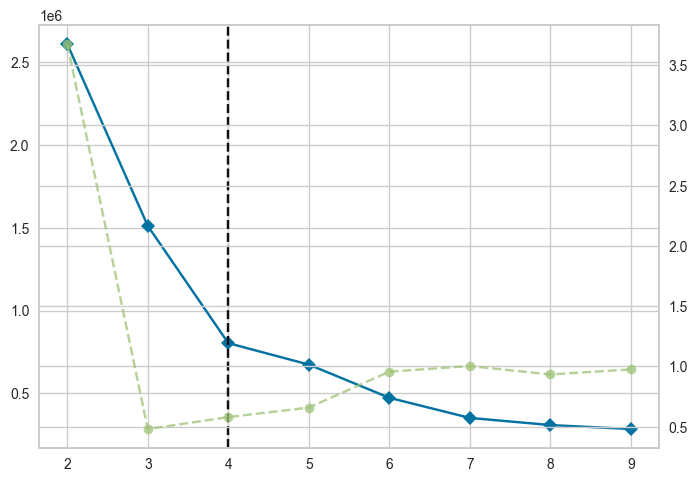

In [31]:
# Scale data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_df[["Recency", "Frequency", "Monetary"]])


# Fit Elbow Visualizer to find optimal K
model = KMeans(random_state=42)
elbow = KElbowVisualizer(model, k=(2, 10))
elbow.fit(scaled_data)

In [32]:
# Final model with selected K
optimal_k = elbow.elbow_value_
print(f"Optimal k value is: {optimal_k}")
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
cluster_df["Cluster"] = kmeans_final.fit_predict(scaled_data)

Optimal k value is: 4


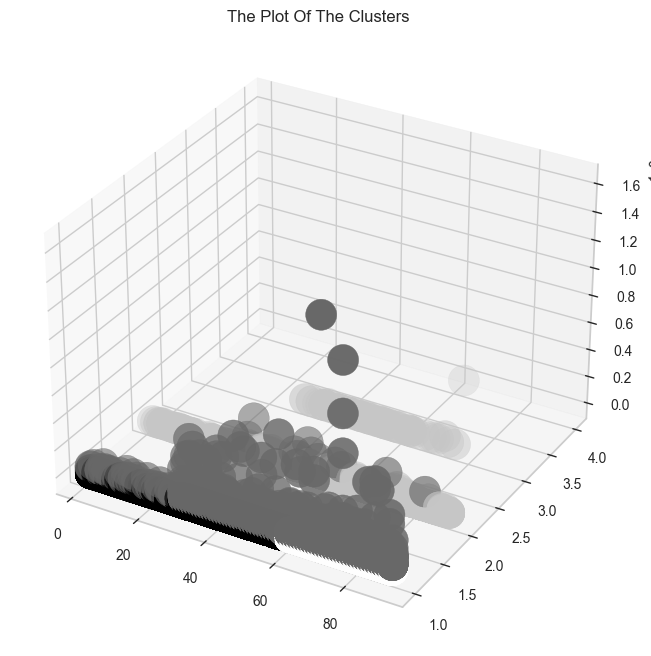

In [43]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot( projection='3d')
ax.scatter(cluster_df['Recency'], cluster_df['Frequency'], cluster_df['Monetary'], s=500, c=cluster_df["Cluster"], marker='o')
ax.set_title("The Plot Of The Clusters")
plt.show()